In [1]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [3]:
from torchvision.transforms import v2 as T
import torch


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ConvertImageDtype(torch.float32))  # Convert image dtype to float32
    transforms.append(T.ToTensor())  # Convert to tensor
    return T.Compose(transforms)


In [3]:
from identification_utils import CustomDataset
import torch.utils

def collate_fn(batch):
    return tuple(zip(*batch))


model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = CustomDataset(base_dir="mixed_ingredients_ds",annotations_file="annotations_coco.json", transforms=get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

d:\Facultate\ELL\food_recognition\.venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Images length 199
Tuples length 199
{'loss_classifier': tensor(1.3220, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2465, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.1878, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0266, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


In [4]:
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [5]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and ingredient
num_classes = 2
# use our dataset and defined transformations
dataset = CustomDataset(base_dir="mixed_ingredients_ds",annotations_file="annotations_coco.json", transforms=get_transform(train=True))
dataset_test = CustomDataset(base_dir="mixed_ingredients_ds",annotations_file="annotations_coco.json", transforms=get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn
)

Images length 199
Tuples length 199
Images length 199
Tuples length 199


In [ ]:
import torch.optim as optim

# Define optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Define learning rate scheduler
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Define number of epochs
num_epochs = 2

model.to(device)
# Training loop
for epoch in range(num_epochs):
    # Set model to training mode
    model.train()
    
    # Iterate over the training dataset
    for images, targets in data_loader:
        # Move images and targets to the device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Clear previous gradients
        optimizer.zero_grad()
        
        # Forward pass
        try:
            loss_dict = model(images, targets)
            
            # Compute total loss
            losses = sum(loss for loss in loss_dict.values())

            print(losses)
            
            # Backward pass
            losses.backward()
            
            # Update weights
            optimizer.step()
        except Exception:
            continue
        
    # Print epoch number
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Update learning rate scheduler
    lr_scheduler.step()

    # Evaluate the model on the test dataset
    model.eval()
    total_loss = 0.0
    for images, targets in data_loader_test:
        # Move images and targets to the device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Forward pass
        with torch.no_grad():
            try:
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                total_loss += losses
            except Exception as e:
                continue
    
    # Print average loss for the test dataset
    avg_loss = total_loss / len(data_loader_test)
    print(f"Average loss: {avg_loss}")

# Save the trained model
torch.save(model.state_dict(), "model.pth")


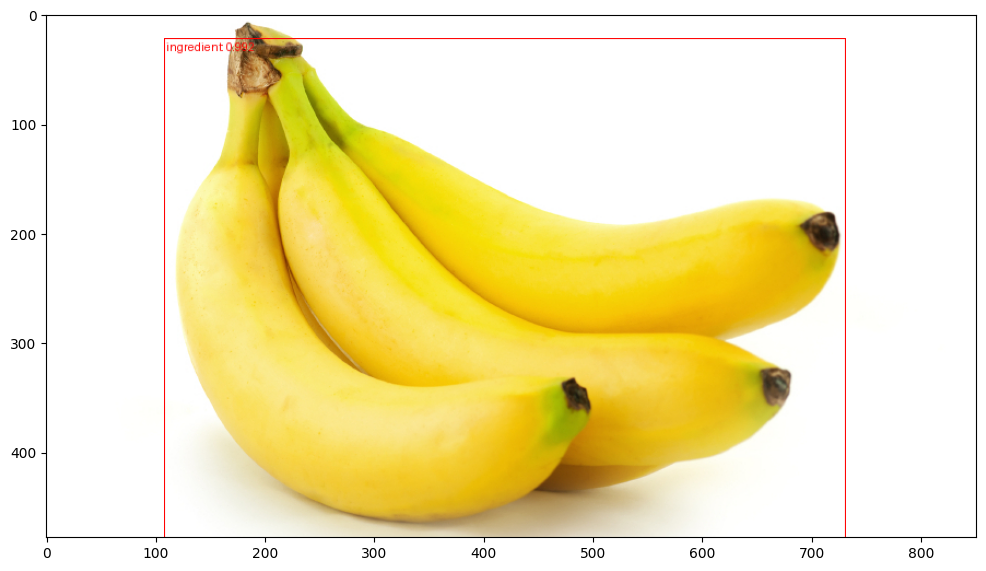

In [ ]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image


image = read_image("D:\\Facultate\\ELL\\food_recognition\\ingredient_identification\\mixed_ingredients_ds\\mixed_ingredients_24.jpg")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


threshold = 0.5
pred_labels = []
pred_boxes = []
for label, score, box in zip(pred["labels"], pred["scores"], pred["boxes"]):
    if score > threshold:
        pred_labels.append(f"ingredient: {score:.3f}")
        pred_boxes.append(box.tolist())  # Convert box tensor to list

# Convert pred_boxes to tensor
pred_boxes = torch.tensor(pred_boxes, dtype=torch.float32)

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))
plt.show()

In [4]:
from identification_utils import CustomDataset


dataset = CustomDataset(base_dir="mixed_ingredients_ds",annotations_file="annotations_coco.json", transforms=get_transform(train=False))
print(len(dataset.data_tuples))

d:\Facultate\ELL\food_recognition\.venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Images length 199
Tuples length 199
199


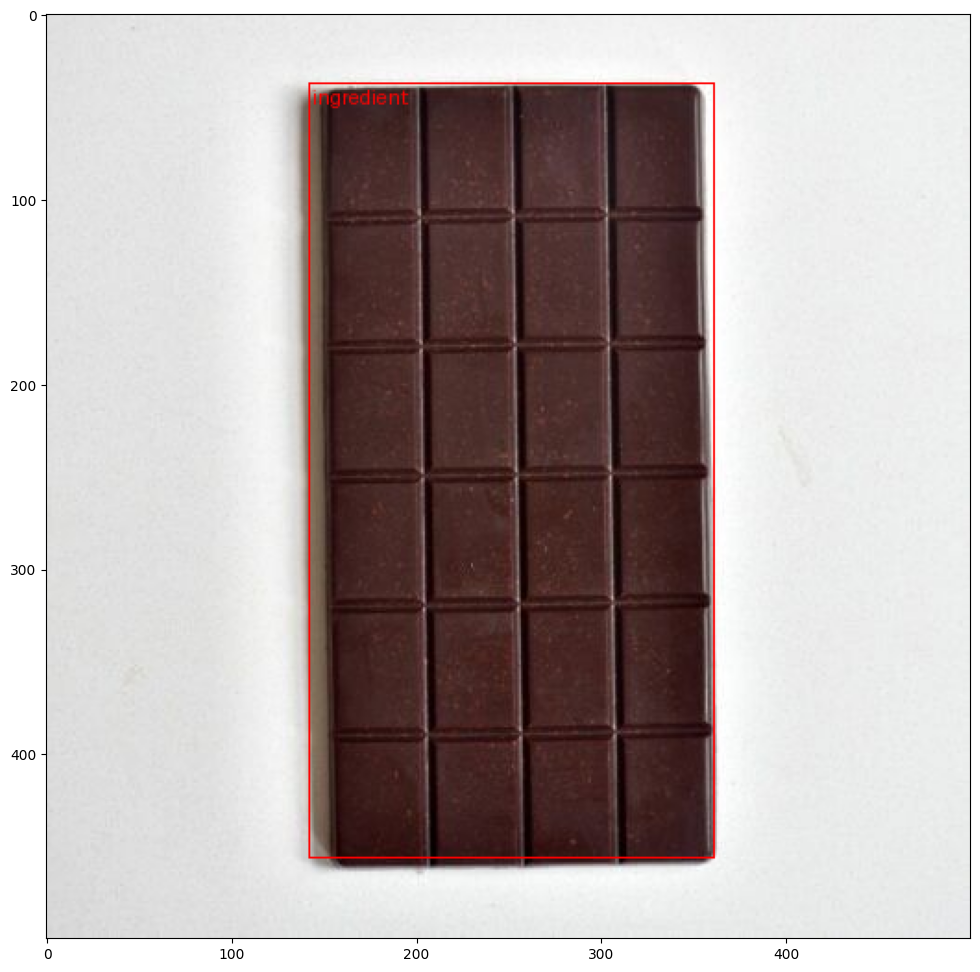

In [12]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes

item = dataset.__getitem__(15)

image = item[0]
boxDict = item[1]

boxes = boxDict['boxes']

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"ingredient: " for _ in boxDict['labels']]
pred_boxes = boxes.long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))